# Stock Market vs IPOs — Online Portfolio Optimizer (OGD)

This notebook is a **focused extension** of the Week 11 Online Gradient Descent portfolio optimizer.
It shows how to build a *two-sleeve* allocator between:
- **Stock market** (e.g., SPY / total market index)
- **IPO sleeve** (either an IPO ETF like `IPO`, or a custom IPO basket built from IPO-level data)

The optimizer runs **online** (walk-forward): at each date *t*, it updates weights using only a trailing window of past returns.


In [1]:
# Core imports
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

# Reproducibility (optional)
np.random.seed(7)
torch.manual_seed(7)


## 1) Data inputs

You need a return series for the **market sleeve** and the **IPO sleeve**.

Supported options below:
1. **CSV with returns** (recommended for reproducibility)
2. **Yahoo Finance via yfinance** (if you have internet access)
3. **Custom IPO basket** from panel data (ticker-level returns + IPO date)


In [2]:
def load_returns_from_csv(path, date_col="date"):
    """Load a CSV containing date + return columns.
    Expected columns (example): date, market_ret, ipo_ret
    Returns a DataFrame indexed by date with float returns.
    """
    df = pd.read_csv(path)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).sort_index()
    # Keep only numeric return columns
    ret = df.select_dtypes(include=[np.number]).copy()
    return ret

def load_returns_with_yfinance(tickers, start="2015-01-01", end=None):
    """Fetch adjusted close from Yahoo Finance and convert to daily returns.
    Requires: pip install yfinance
    """
    try:
        import yfinance as yf
    except Exception as e:
        raise ImportError("yfinance not installed. Run: pip install yfinance") from e

    px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    px = px.dropna(how="all")
    rets = px.pct_change().dropna()
    rets.columns = list(tickers)
    return rets


### 1.1 Build an IPO basket from panel data (optional)

If you have IPO-level data (e.g., from CRSP/Compustat, Refinitiv, etc.), you can build an IPO sleeve by:
- selecting stocks within *N* trading days since IPO (e.g., first 252 days)
- equal-weighting (or value-weighting) those names each day

Input panel schema:
- `date` (daily)
- `ticker`
- `ret` (daily return)
- `ipo_date` (first trading date)


In [3]:
def build_ipo_basket_returns(panel: pd.DataFrame,
                             holding_days: int = 252,
                             min_names: int = 10) -> pd.Series:
    """Create an equal-weight IPO basket from a panel.

    Parameters
    ----------
    panel : DataFrame
        Columns: date, ticker, ret, ipo_date
    holding_days : int
        Include tickers from IPO date up to this many trading days after IPO.
    min_names : int
        If fewer than this many IPO names are available on a day, basket return is NaN.

    Returns
    -------
    Series indexed by date: ipo_basket_ret
    """
    req = {"date", "ticker", "ret", "ipo_date"}
    missing = req - set(panel.columns)
    if missing:
        raise ValueError(f"panel is missing columns: {sorted(missing)}")

    df = panel.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["ipo_date"] = pd.to_datetime(df["ipo_date"])
    df = df.sort_values(["date", "ticker"])

    # Trading-day age approximation: rank dates within each ticker
    df["age"] = df.groupby("ticker")["date"].rank(method="first").astype(int) - 1

    # Keep only first `holding_days` trading days post-IPO
    df = df[(df["age"] >= 0) & (df["age"] < holding_days)]

    # Equal-weight each day
    g = df.groupby("date")
    counts = g["ret"].count()
    basket = g["ret"].mean()

    basket[counts < min_names] = np.nan
    basket.name = "ipo_ret"
    return basket


## 2) Convert returns to a price index (for drawdown)

The optimizer below operates on **returns**, but some diagnostics (like drawdown) are easiest on a price index.


In [4]:
def returns_to_price_index(returns: pd.DataFrame, start_value: float = 100.0) -> pd.DataFrame:
    px = (1.0 + returns.fillna(0.0)).cumprod() * start_value
    return px


## 3) Online Gradient Descent allocator

Objective (maximized on a trailing window):
- mean portfolio return
- minus risk penalty (variance)
- minus max drawdown penalty
- minus turnover penalty (L1 distance from previous weights)

Constraints:
- long-only
- weights sum to 1 (simplex projection)


In [5]:
def project_to_simplex(v: torch.Tensor) -> torch.Tensor:
    """Euclidean projection onto the probability simplex."""
    if v.ndim != 1:
        raise ValueError("v must be a 1D tensor")
    n = v.numel()
    # Sort descending
    u, _ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u, dim=0) - 1
    ind = torch.arange(1, n + 1, device=v.device, dtype=v.dtype)
    cond = u - cssv / ind > 0
    if not torch.any(cond):
        return torch.ones_like(v) / n
    rho = torch.nonzero(cond, as_tuple=False)[-1].item()
    theta = cssv[rho] / (rho + 1.0)
    w = torch.clamp(v - theta, min=0.0)
    # Numerical stability: renormalize
    s = w.sum()
    return w / s if s > 0 else torch.ones_like(v) / n

def max_drawdown_from_returns(port_ret: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Differentiable-ish max drawdown based on cumulative product."""
    cum = torch.cumprod(1.0 + port_ret, dim=0)
    peak, _ = torch.cummax(cum, dim=0)
    dd = cum / (peak + eps) - 1.0
    return torch.min(dd)  # negative number (e.g., -0.25)

class OnlineOGDAllocator:
    def __init__(self,
                 n_assets: int,
                 window: int = 252,
                 lr: float = 0.10,
                 lr_decay: float = 0.999,
                 risk_aversion: float = 10.0,
                 drawdown_penalty: float = 5.0,
                 turnover_penalty: float = 0.25,
                 device: str = "cpu"):

        self.n_assets = n_assets
        self.window = int(window)
        self.lr0 = float(lr)
        self.lr_decay = float(lr_decay)
        self.risk_aversion = float(risk_aversion)
        self.drawdown_penalty = float(drawdown_penalty)
        self.turnover_penalty = float(turnover_penalty)
        self.device = device

        self.t = 0
        self.w = torch.ones(n_assets, device=device) / n_assets
        self.w_prev = self.w.clone()

    def step(self, window_returns: np.ndarray) -> np.ndarray:
        """Update weights using trailing window returns (T x n_assets)."""
        self.t += 1
        lr = self.lr0 * (self.lr_decay ** (self.t - 1))

        R = torch.tensor(window_returns, device=self.device, dtype=torch.float32)
        # Decision variable
        w_var = self.w.clone().detach().requires_grad_(True)

        port = R @ w_var  # (T,)
        mu = port.mean()
        var = port.var(unbiased=False)

        mdd = max_drawdown_from_returns(port)
        turnover = torch.sum(torch.abs(w_var - self.w_prev))

        # maximize utility => minimize negative utility
        utility = mu - self.risk_aversion * var + self.drawdown_penalty * mdd - self.turnover_penalty * turnover
        loss = -utility
        loss.backward()

        grad = w_var.grad.detach()

        # Gradient ascent step (since maximizing utility)
        w_new = self.w + lr * (-grad) * 0.0  # placeholder

        # We used loss = -utility, so grad(loss)= -grad(utility)
        # To ascend utility: w <- w + lr * grad(utility) = w - lr * grad(loss)
        w_new = self.w - lr * grad

        w_new = project_to_simplex(w_new)
        self.w_prev = self.w.clone()
        self.w = w_new.detach()
        return self.w.cpu().numpy()


## 4) Example walk-forward run (using IPO data)

**Step 1:** Load returns in the cell below. We use SPY (market) and the Renaissance IPO ETF (`IPO`) via yfinance. You can swap in other tickers or use `load_returns_from_csv` / `build_ipo_basket_returns` from Section 1.

**Step 2:** Run the walk-forward cells to:
1. Perform OGD optimization on the trailing window
2. Plot cumulative returns (OGD vs equal-weight vs market-only)
3. Plot portfolio weights over time

In [6]:
# 4.0 Load returns (market + IPO sleeve)
# Using SPY (S&P 500) and Renaissance IPO ETF as proxies. Requires: pip install yfinance

rets = load_returns_with_yfinance(["SPY", "IPO"], start="2015-01-01")
rets = rets.dropna()
rets.columns = ["MARKET", "IPO"]
rets

C:\Users\ocean\AppData\Local\Temp\ipykernel_219424\1716844289.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = px.pct_change().dropna()


,MARKET,IPO
Date,,
2015-01-05,-0.014084,-0.018060
2015-01-06,0.005357,-0.009419
2015-01-07,0.001776,0.012461
2015-01-08,0.020833,0.017745
2015-01-09,0.001737,-0.008014
...,...,...
2026-01-30,-0.031873,-0.002983
2026-02-02,-0.007167,0.004971
2026-02-03,-0.011505,-0.008455


In [7]:
# 4.1 Walk-forward optimization on `rets` (from cell above)

if rets.shape[1] != 2:
    raise ValueError(f"`rets` should have exactly 2 return columns (market, IPO sleeve). Got shape {rets.shape}.")

window = 252

alloc = OnlineOGDAllocator(
    n_assets=rets.shape[1],
    window=window,
    lr=0.15,
    lr_decay=0.999,
    risk_aversion=25.0,
    drawdown_penalty=5.0,
    turnover_penalty=0.10,
)

weights = []
out_dates = []

for i in range(window, len(rets)):
    w = alloc.step(rets.iloc[i - window : i].values)
    weights.append(w)
    out_dates.append(rets.index[i])

w_df = pd.DataFrame(weights, index=out_dates, columns=rets.columns)
w_df.tail()

,MARKET,IPO
2026-01-30,0.0,1.0
2026-02-02,0.0,1.0
2026-02-03,0.0,1.0
2026-02-04,0.0,1.0
2026-02-05,0.0,1.0


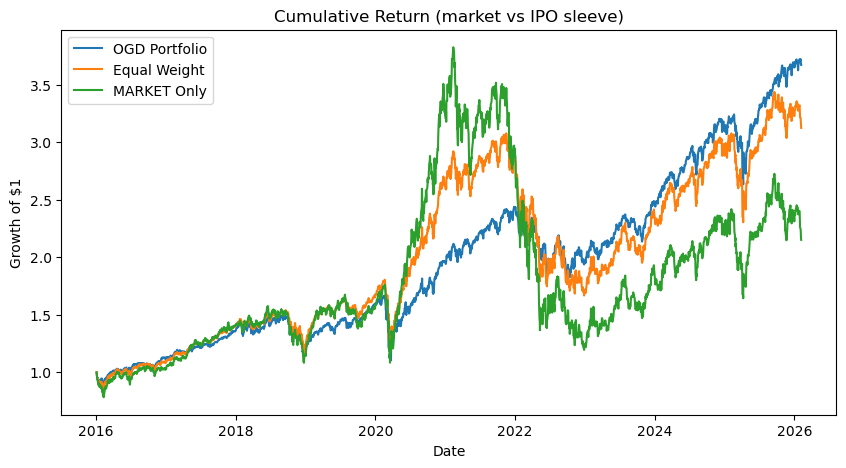

In [8]:
# 4.2 Portfolio backtest (apply weights one-day-ahead to avoid lookahead)

aligned_rets = rets.loc[w_df.index]
port_ret = (aligned_rets.values * w_df.values).sum(axis=1)
port_ret = pd.Series(port_ret, index=w_df.index, name="PORT")

eqw_ret = aligned_rets.mean(axis=1)

# Treat the first column of `rets` as the market sleeve for plotting
market_col = aligned_rets.columns[0]
mkt_ret = aligned_rets[market_col]

cum = (1 + pd.concat([
    port_ret,
    eqw_ret.rename("EQW"),
    mkt_ret.rename(market_col),
], axis=1)).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cum.index, cum["PORT"], label="OGD Portfolio")
plt.plot(cum.index, cum["EQW"], label="Equal Weight")
plt.plot(cum.index, cum[market_col], label=f"{market_col} Only")
plt.legend()
plt.title("Cumulative Return (market vs IPO sleeve)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.show()

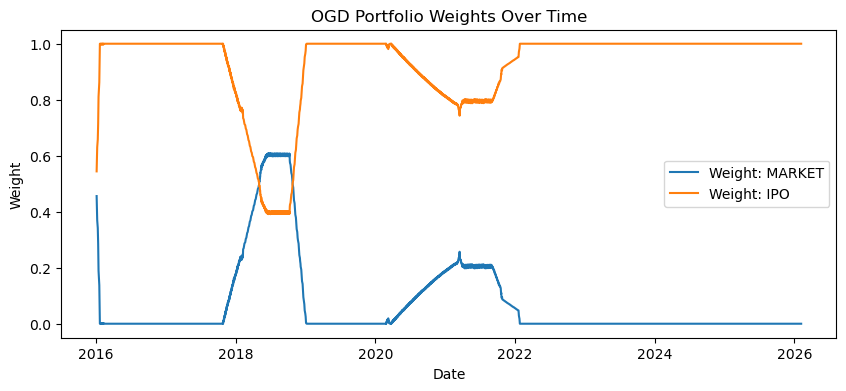

In [9]:
# 4.3 Portfolio weights over time

plt.figure(figsize=(10, 4))
for col in w_df.columns:
    plt.plot(w_df.index, w_df[col], label=f"Weight: {col}")
plt.legend()
plt.title("OGD Portfolio Weights Over Time")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.show()